In [19]:
# Optimized Deep Learning Pipeline for Image Classification

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Dataset path
dataset_path = "/content/drive/MyDrive/CropCare/Cotton"

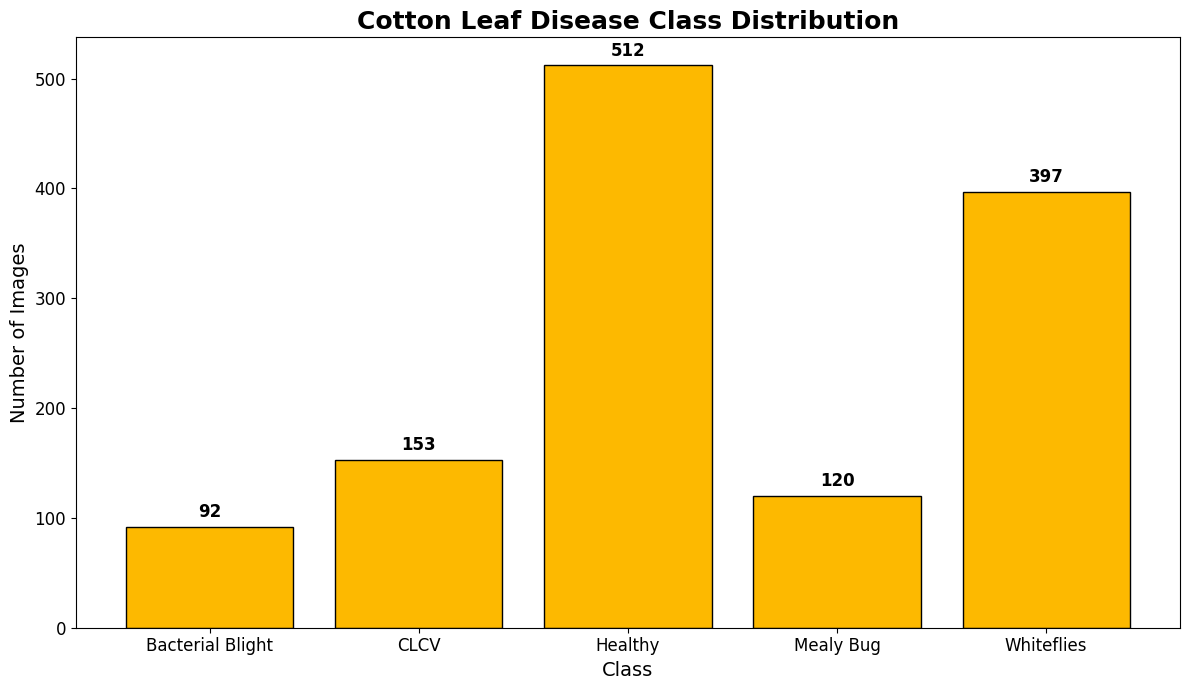

In [4]:
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len([
            f for f in os.listdir(class_dir)
            if os.path.isfile(os.path.join(class_dir, f))
        ])

# Sort by class name
class_counts = dict(sorted(class_counts.items()))

# Plotting
plt.figure(figsize=(12, 7))
bars = plt.bar(
    class_counts.keys(),
    class_counts.values(),
    color='#fdb900',
    edgecolor='black'
)

# Title and axis labels
plt.title("Cotton Leaf Disease Class Distribution", fontsize=18, fontweight='bold')
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate bar values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        str(height),
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

plt.tight_layout()
# plt.savefig("class_distribution_improved.png", dpi=300)
plt.show()

In [5]:
# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)
class_names = full_dataset.classes

In [7]:
# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

In [8]:
# Compute class weights
train_labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [9]:
# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [10]:
# Define Model Architectures
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [16]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2, 2))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [20]:
# Reusable train and evaluation functions
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.to(device)
    train_acc_list, val_acc_list, loss_list = [], [], []
    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        loss_list.append(running_loss / len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {running_loss:.4f}")
    return train_acc_list, val_acc_list, loss_list

In [21]:
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [22]:
def test_model(model, test_loader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.numpy())
    return np.array(preds), np.array(true_labels)

In [23]:
def report_results(model_name, model, test_loader):
    preds, labels = test_model(model, test_loader)
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(labels, preds, target_names=class_names))
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=90, cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()


In [19]:
# Train SimpleCNN
simplecnn = SimpleCNN(len(class_names)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(simplecnn.parameters(), lr=1e-4)
simple_train_acc, simple_val_acc, _ = train_model(simplecnn, train_loader, val_loader, criterion, optimizer)

Epoch 1/20: 100%|██████████| 28/28 [01:02<00:00,  2.22s/it]


Epoch [1/20] | Train Acc: 0.4433 | Val Acc: 0.6063 | Loss: 42.2132


Epoch 2/20: 100%|██████████| 28/28 [01:01<00:00,  2.20s/it]


Epoch [2/20] | Train Acc: 0.6319 | Val Acc: 0.6732 | Loss: 32.2163


Epoch 3/20: 100%|██████████| 28/28 [01:03<00:00,  2.28s/it]


Epoch [3/20] | Train Acc: 0.7138 | Val Acc: 0.7323 | Loss: 25.5307


Epoch 4/20: 100%|██████████| 28/28 [01:03<00:00,  2.26s/it]


Epoch [4/20] | Train Acc: 0.8159 | Val Acc: 0.7992 | Loss: 19.8750


Epoch 5/20: 100%|██████████| 28/28 [01:01<00:00,  2.20s/it]


Epoch [5/20] | Train Acc: 0.8586 | Val Acc: 0.7756 | Loss: 15.6350


Epoch 6/20: 100%|██████████| 28/28 [01:02<00:00,  2.24s/it]


Epoch [6/20] | Train Acc: 0.8664 | Val Acc: 0.7992 | Loss: 14.7160


Epoch 7/20: 100%|██████████| 28/28 [01:05<00:00,  2.33s/it]


Epoch [7/20] | Train Acc: 0.8709 | Val Acc: 0.8189 | Loss: 12.2233


Epoch 8/20: 100%|██████████| 28/28 [01:03<00:00,  2.27s/it]


Epoch [8/20] | Train Acc: 0.9192 | Val Acc: 0.8031 | Loss: 8.9189


Epoch 9/20: 100%|██████████| 28/28 [01:01<00:00,  2.21s/it]


Epoch [9/20] | Train Acc: 0.9383 | Val Acc: 0.8031 | Loss: 7.4363


Epoch 10/20: 100%|██████████| 28/28 [01:01<00:00,  2.20s/it]


Epoch [10/20] | Train Acc: 0.9394 | Val Acc: 0.8228 | Loss: 6.3777


Epoch 11/20: 100%|██████████| 28/28 [01:03<00:00,  2.28s/it]


Epoch [11/20] | Train Acc: 0.9562 | Val Acc: 0.8425 | Loss: 5.0436


Epoch 12/20: 100%|██████████| 28/28 [01:03<00:00,  2.27s/it]


Epoch [12/20] | Train Acc: 0.9630 | Val Acc: 0.8150 | Loss: 4.5134


Epoch 13/20: 100%|██████████| 28/28 [01:05<00:00,  2.34s/it]


Epoch [13/20] | Train Acc: 0.9630 | Val Acc: 0.8268 | Loss: 3.8208


Epoch 14/20: 100%|██████████| 28/28 [01:03<00:00,  2.27s/it]


Epoch [14/20] | Train Acc: 0.9708 | Val Acc: 0.8346 | Loss: 3.7282


Epoch 15/20: 100%|██████████| 28/28 [01:03<00:00,  2.26s/it]


Epoch [15/20] | Train Acc: 0.9787 | Val Acc: 0.8031 | Loss: 3.7481


Epoch 16/20: 100%|██████████| 28/28 [01:04<00:00,  2.31s/it]


Epoch [16/20] | Train Acc: 0.9652 | Val Acc: 0.8110 | Loss: 3.6455


Epoch 17/20: 100%|██████████| 28/28 [01:03<00:00,  2.27s/it]


Epoch [17/20] | Train Acc: 0.9776 | Val Acc: 0.8268 | Loss: 2.7333


Epoch 18/20: 100%|██████████| 28/28 [01:02<00:00,  2.24s/it]


Epoch [18/20] | Train Acc: 0.9820 | Val Acc: 0.8425 | Loss: 2.4841


Epoch 19/20: 100%|██████████| 28/28 [01:03<00:00,  2.27s/it]


Epoch [19/20] | Train Acc: 0.9742 | Val Acc: 0.8504 | Loss: 2.6446


Epoch 20/20: 100%|██████████| 28/28 [01:05<00:00,  2.35s/it]


Epoch [20/20] | Train Acc: 0.9865 | Val Acc: 0.8189 | Loss: 2.1597



Classification Report (SimpleCNN):
                  precision    recall  f1-score   support

Bacterial Blight       0.67      0.67      0.67        12
            CLCV       0.88      0.47      0.61        15
         Healthy       0.98      1.00      0.99        57
       Mealy Bug       0.64      0.82      0.72        11
      Whiteflies       0.78      0.85      0.81        33

        accuracy                           0.85       128
       macro avg       0.79      0.76      0.76       128
    weighted avg       0.86      0.85      0.85       128



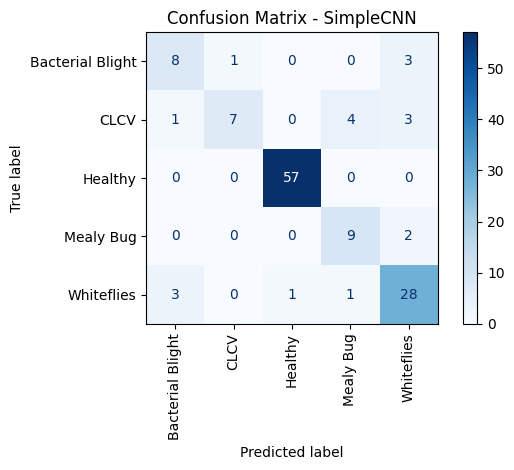

In [20]:
report_results("SimpleCNN", simplecnn, test_loader)

In [21]:
# Train DeepCNN
deepcnn = DeepCNN(len(class_names)).to(device)
optimizer = optim.Adam(deepcnn.parameters(), lr=1e-4)
deep_train_acc, deep_val_acc, _ = train_model(deepcnn, train_loader, val_loader, criterion, optimizer)

Epoch 1/20: 100%|██████████| 28/28 [01:07<00:00,  2.42s/it]


Epoch [1/20] | Train Acc: 0.5432 | Val Acc: 0.7047 | Loss: 37.5472


Epoch 2/20: 100%|██████████| 28/28 [01:02<00:00,  2.24s/it]


Epoch [2/20] | Train Acc: 0.7845 | Val Acc: 0.7913 | Loss: 26.2675


Epoch 3/20: 100%|██████████| 28/28 [01:02<00:00,  2.22s/it]


Epoch [3/20] | Train Acc: 0.8294 | Val Acc: 0.7874 | Loss: 21.2258


Epoch 4/20: 100%|██████████| 28/28 [01:03<00:00,  2.28s/it]


Epoch [4/20] | Train Acc: 0.8328 | Val Acc: 0.7992 | Loss: 19.6334


Epoch 5/20: 100%|██████████| 28/28 [01:06<00:00,  2.39s/it]


Epoch [5/20] | Train Acc: 0.8485 | Val Acc: 0.8386 | Loss: 17.2483


Epoch 6/20: 100%|██████████| 28/28 [01:06<00:00,  2.37s/it]


Epoch [6/20] | Train Acc: 0.8653 | Val Acc: 0.8307 | Loss: 16.5838


Epoch 7/20: 100%|██████████| 28/28 [01:05<00:00,  2.33s/it]


Epoch [7/20] | Train Acc: 0.8698 | Val Acc: 0.8504 | Loss: 15.5801


Epoch 8/20: 100%|██████████| 28/28 [01:04<00:00,  2.31s/it]


Epoch [8/20] | Train Acc: 0.8765 | Val Acc: 0.8268 | Loss: 13.9717


Epoch 9/20: 100%|██████████| 28/28 [01:04<00:00,  2.31s/it]


Epoch [9/20] | Train Acc: 0.8866 | Val Acc: 0.8386 | Loss: 12.3954


Epoch 10/20: 100%|██████████| 28/28 [01:04<00:00,  2.32s/it]


Epoch [10/20] | Train Acc: 0.8923 | Val Acc: 0.8189 | Loss: 12.0386


Epoch 11/20: 100%|██████████| 28/28 [01:03<00:00,  2.28s/it]


Epoch [11/20] | Train Acc: 0.8900 | Val Acc: 0.8228 | Loss: 12.2239


Epoch 12/20: 100%|██████████| 28/28 [01:02<00:00,  2.23s/it]


Epoch [12/20] | Train Acc: 0.8889 | Val Acc: 0.8150 | Loss: 11.6406


Epoch 13/20: 100%|██████████| 28/28 [01:06<00:00,  2.37s/it]


Epoch [13/20] | Train Acc: 0.8844 | Val Acc: 0.8425 | Loss: 12.1084


Epoch 14/20: 100%|██████████| 28/28 [01:08<00:00,  2.43s/it]


Epoch [14/20] | Train Acc: 0.8923 | Val Acc: 0.7756 | Loss: 11.5422


Epoch 15/20: 100%|██████████| 28/28 [01:07<00:00,  2.43s/it]


Epoch [15/20] | Train Acc: 0.8990 | Val Acc: 0.8465 | Loss: 10.2813


Epoch 16/20: 100%|██████████| 28/28 [01:02<00:00,  2.23s/it]


Epoch [16/20] | Train Acc: 0.9001 | Val Acc: 0.8622 | Loss: 9.1324


Epoch 17/20: 100%|██████████| 28/28 [01:03<00:00,  2.27s/it]


Epoch [17/20] | Train Acc: 0.9147 | Val Acc: 0.8622 | Loss: 8.9241


Epoch 18/20: 100%|██████████| 28/28 [01:01<00:00,  2.20s/it]


Epoch [18/20] | Train Acc: 0.9203 | Val Acc: 0.8268 | Loss: 8.3919


Epoch 19/20: 100%|██████████| 28/28 [01:02<00:00,  2.25s/it]


Epoch [19/20] | Train Acc: 0.9315 | Val Acc: 0.8701 | Loss: 7.4565


Epoch 20/20: 100%|██████████| 28/28 [01:10<00:00,  2.50s/it]


Epoch [20/20] | Train Acc: 0.9551 | Val Acc: 0.8465 | Loss: 5.9866



Classification Report (DeepCNN):
                  precision    recall  f1-score   support

Bacterial Blight       0.88      0.58      0.70        12
            CLCV       1.00      0.93      0.97        15
         Healthy       1.00      1.00      1.00        57
       Mealy Bug       0.47      0.82      0.60        11
      Whiteflies       0.97      0.88      0.92        33

        accuracy                           0.91       128
       macro avg       0.86      0.84      0.84       128
    weighted avg       0.93      0.91      0.91       128



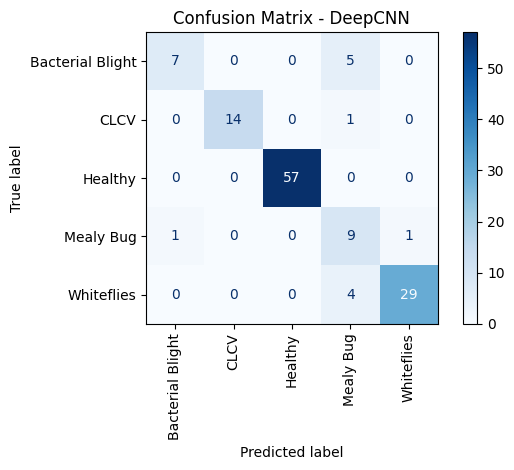

In [22]:
report_results("DeepCNN", deepcnn, test_loader)

In [24]:
# Train ResNet50
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, len(class_names))
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)
resnet_train_acc, resnet_val_acc, _ = train_model(resnet, train_loader, val_loader, criterion, optimizer)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]



Classification Report (ResNet50):
                  precision    recall  f1-score   support

Bacterial Blight       0.89      0.67      0.76        12
            CLCV       1.00      0.93      0.97        15
         Healthy       0.97      1.00      0.98        57
       Mealy Bug       0.64      0.82      0.72        11
      Whiteflies       0.97      0.94      0.95        33

        accuracy                           0.93       128
       macro avg       0.89      0.87      0.88       128
    weighted avg       0.94      0.93      0.93       128



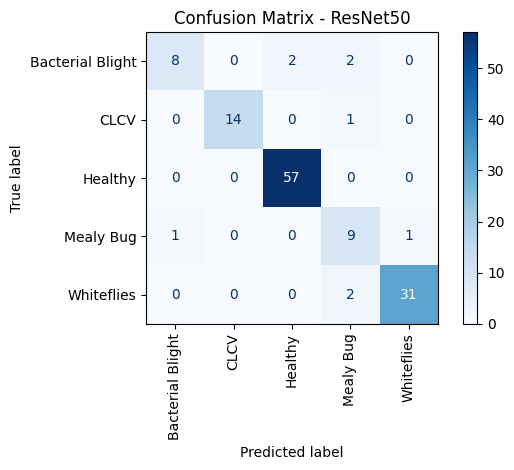

In [24]:
report_results("ResNet50", resnet, test_loader)

In [26]:
# Train VGG16
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device)
for param in vgg.parameters():
    param.requires_grad = False
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, len(class_names))
optimizer = optim.Adam(vgg.classifier[6].parameters(), lr=1e-3)
vgg_train_acc, vgg_val_acc, _ = train_model(vgg, train_loader, val_loader, criterion, optimizer)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 75.7MB/s]
Epoch 1/20: 100%|██████████| 28/28 [00:55<00:00,  1.99s/it]


Epoch [1/20] | Train Acc: 0.7374 | Val Acc: 0.9094 | Loss: 26.3337


Epoch 2/20: 100%|██████████| 28/28 [00:55<00:00,  1.99s/it]


Epoch [2/20] | Train Acc: 0.9035 | Val Acc: 0.9055 | Loss: 11.0627


Epoch 3/20: 100%|██████████| 28/28 [00:55<00:00,  1.99s/it]


Epoch [3/20] | Train Acc: 0.9270 | Val Acc: 0.9055 | Loss: 8.2532


Epoch 4/20: 100%|██████████| 28/28 [00:56<00:00,  2.03s/it]


Epoch [4/20] | Train Acc: 0.9450 | Val Acc: 0.9331 | Loss: 7.0858


Epoch 5/20: 100%|██████████| 28/28 [00:56<00:00,  2.03s/it]


Epoch [5/20] | Train Acc: 0.9439 | Val Acc: 0.9173 | Loss: 6.0535


Epoch 6/20: 100%|██████████| 28/28 [00:57<00:00,  2.05s/it]


Epoch [6/20] | Train Acc: 0.9540 | Val Acc: 0.9331 | Loss: 5.3771


Epoch 7/20: 100%|██████████| 28/28 [00:59<00:00,  2.11s/it]


Epoch [7/20] | Train Acc: 0.9551 | Val Acc: 0.9331 | Loss: 4.7790


Epoch 8/20: 100%|██████████| 28/28 [00:55<00:00,  1.99s/it]


Epoch [8/20] | Train Acc: 0.9663 | Val Acc: 0.9291 | Loss: 4.0786


Epoch 9/20: 100%|██████████| 28/28 [00:55<00:00,  2.00s/it]


Epoch [9/20] | Train Acc: 0.9719 | Val Acc: 0.9370 | Loss: 3.5850


Epoch 10/20: 100%|██████████| 28/28 [00:57<00:00,  2.07s/it]


Epoch [10/20] | Train Acc: 0.9630 | Val Acc: 0.9213 | Loss: 3.9293


Epoch 11/20: 100%|██████████| 28/28 [00:55<00:00,  1.99s/it]


Epoch [11/20] | Train Acc: 0.9686 | Val Acc: 0.9409 | Loss: 3.4365


Epoch 12/20: 100%|██████████| 28/28 [00:55<00:00,  1.98s/it]


Epoch [12/20] | Train Acc: 0.9731 | Val Acc: 0.9213 | Loss: 2.8063


Epoch 13/20: 100%|██████████| 28/28 [00:55<00:00,  1.99s/it]


Epoch [13/20] | Train Acc: 0.9686 | Val Acc: 0.9331 | Loss: 2.9617


Epoch 14/20: 100%|██████████| 28/28 [00:55<00:00,  1.98s/it]


Epoch [14/20] | Train Acc: 0.9742 | Val Acc: 0.9409 | Loss: 2.7305


Epoch 15/20: 100%|██████████| 28/28 [00:54<00:00,  1.96s/it]


Epoch [15/20] | Train Acc: 0.9742 | Val Acc: 0.9331 | Loss: 2.8183


Epoch 16/20: 100%|██████████| 28/28 [00:55<00:00,  1.97s/it]


Epoch [16/20] | Train Acc: 0.9753 | Val Acc: 0.9331 | Loss: 2.5891


Epoch 17/20: 100%|██████████| 28/28 [00:56<00:00,  2.01s/it]


Epoch [17/20] | Train Acc: 0.9798 | Val Acc: 0.9331 | Loss: 2.3492


Epoch 18/20: 100%|██████████| 28/28 [00:58<00:00,  2.10s/it]


Epoch [18/20] | Train Acc: 0.9776 | Val Acc: 0.9409 | Loss: 2.3343


Epoch 19/20: 100%|██████████| 28/28 [00:56<00:00,  2.00s/it]


Epoch [19/20] | Train Acc: 0.9854 | Val Acc: 0.9291 | Loss: 2.1494


Epoch 20/20: 100%|██████████| 28/28 [00:55<00:00,  1.97s/it]


Epoch [20/20] | Train Acc: 0.9809 | Val Acc: 0.9291 | Loss: 2.0002



Classification Report (VGG16):
                  precision    recall  f1-score   support

Bacterial Blight       1.00      0.75      0.86        12
            CLCV       0.88      0.93      0.90        15
         Healthy       0.98      1.00      0.99        57
       Mealy Bug       0.77      0.91      0.83        11
      Whiteflies       0.97      0.94      0.95        33

        accuracy                           0.95       128
       macro avg       0.92      0.91      0.91       128
    weighted avg       0.95      0.95      0.95       128



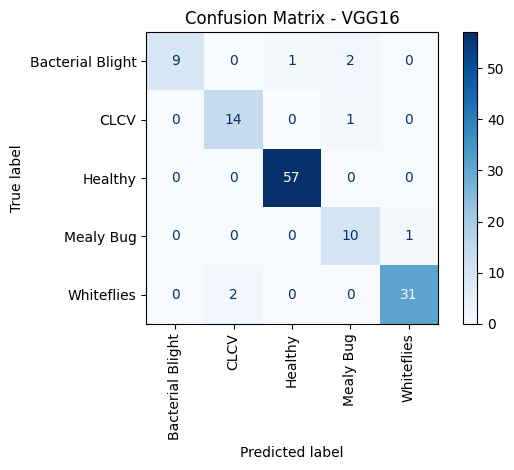

In [27]:
report_results("VGG16", vgg, test_loader)

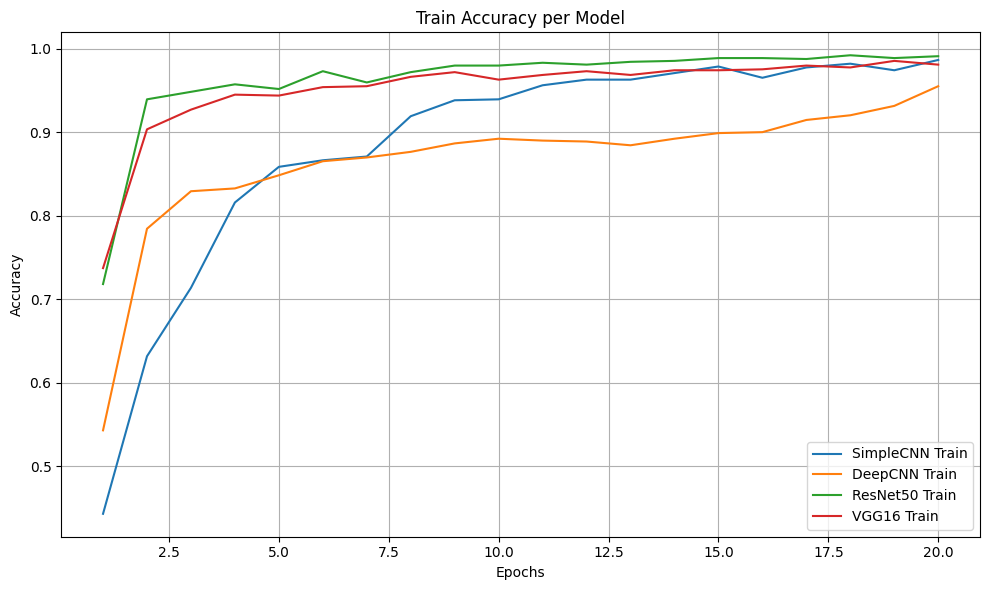

In [34]:
# Accuracy curves
plt.figure(figsize=(10, 6))
epochs = range(1, len(simple_train_acc)+1)

plt.plot(epochs, simple_train_acc, label='SimpleCNN Train')
plt.plot(epochs, deep_train_acc, label='DeepCNN Train')
plt.plot(epochs, resnet_train_acc, label='ResNet50 Train')
plt.plot(epochs, vgg_train_acc, label='VGG16 Train')

plt.title('Train Accuracy per Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


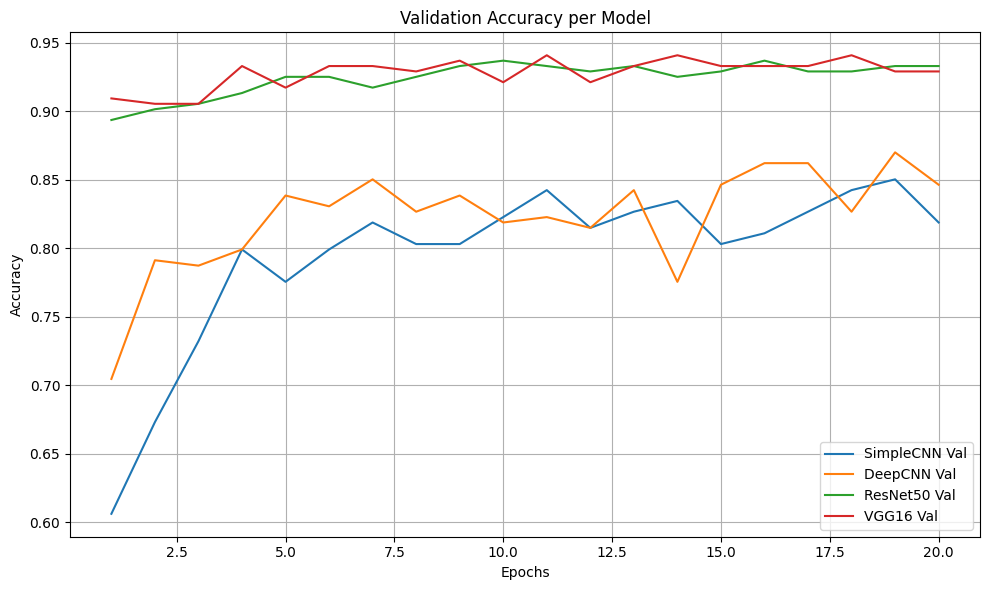

In [33]:
# Accuracy curves
plt.figure(figsize=(10, 6))
epochs = range(1, len(simple_train_acc)+1)

# plt.plot(epochs, simple_train_acc, label='SimpleCNN Train')
plt.plot(epochs, simple_val_acc, label='SimpleCNN Val')

# plt.plot(epochs, deep_train_acc, label='DeepCNN Train')
plt.plot(epochs, deep_val_acc, label='DeepCNN Val')

# plt.plot(epochs, resnet_train_acc, label='ResNet50 Train')
plt.plot(epochs, resnet_val_acc, label='ResNet50 Val')

# plt.plot(epochs, vgg_train_acc, label='VGG16 Train')
plt.plot(epochs, vgg_val_acc, label='VGG16 Val')

plt.title('Validation Accuracy per Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(model, loader):
    preds, labels = test_model(model, loader)
    accuracy = np.mean(preds == labels)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1

# Compute all metrics
metrics_dict = {
    "SimpleCNN": compute_metrics(simplecnn, test_loader),
    "DeepCNN": compute_metrics(deepcnn, test_loader),
    "ResNet50": compute_metrics(resnet, test_loader),
    "VGG16": compute_metrics(vgg, test_loader)
}

# Convert to arrays for plotting
model_names = list(metrics_dict.keys())
accuracies = [metrics_dict[m][0] for m in model_names]
precisions = [metrics_dict[m][1] for m in model_names]
recalls = [metrics_dict[m][2] for m in model_names]
f1_scores = [metrics_dict[m][3] for m in model_names]


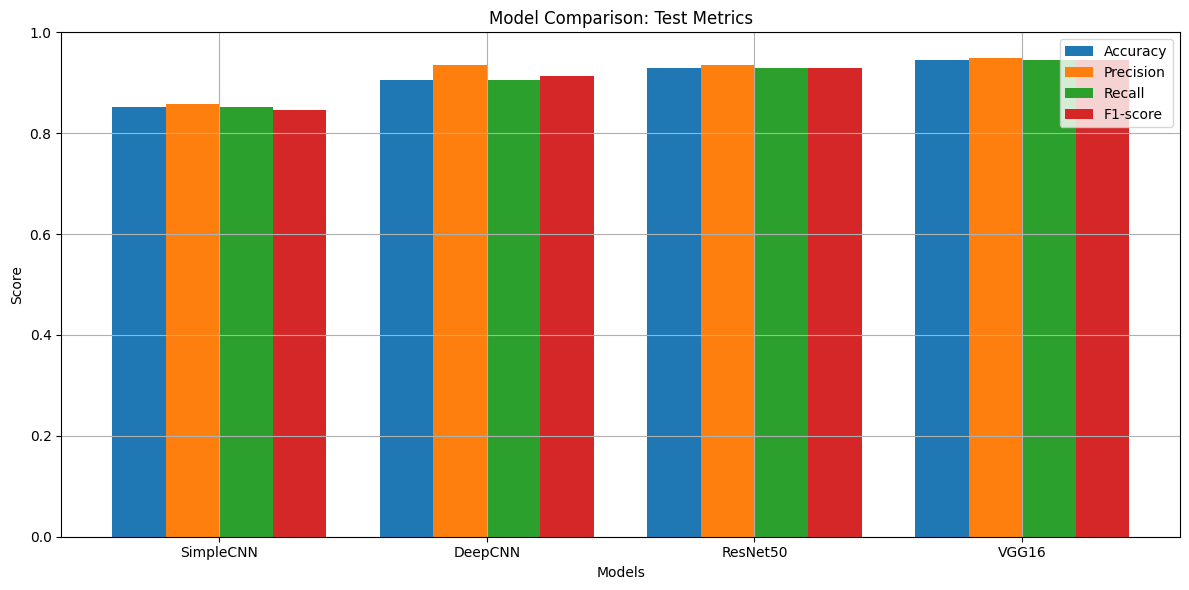

In [30]:
x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
plt.bar(x - 0.5*width, precisions, width, label='Precision')
plt.bar(x + 0.5*width, recalls, width, label='Recall')
plt.bar(x + 1.5*width, f1_scores, width, label='F1-score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Comparison: Test Metrics')
plt.xticks(x, model_names)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
import pandas as pd

df_metrics = pd.DataFrame(metrics_dict, index=["Accuracy", "Precision", "Recall", "F1-score"]).T
print("\nComparative Performance Summary:")
print(df_metrics.round(4))



Comparative Performance Summary:
           Accuracy  Precision  Recall  F1-score
SimpleCNN    0.8516     0.8584  0.8516    0.8464
DeepCNN      0.9062     0.9345  0.9062    0.9130
ResNet50     0.9297     0.9357  0.9297    0.9300
VGG16        0.9453     0.9498  0.9453    0.9452


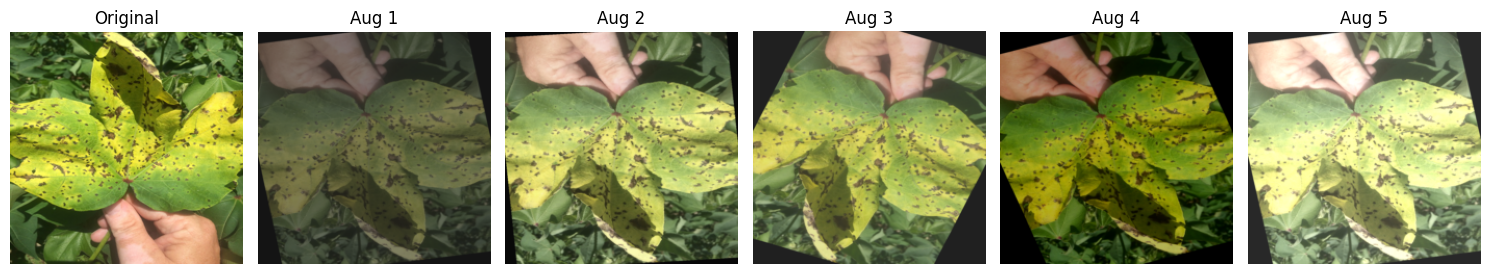

In [1]:
from PIL import Image


img_path = '/content/drive/MyDrive/CropCare/Cotton/Bacterial Blight/374.jpg'
image = Image.open(img_path).convert('RGB')

# Define augmentation transforms (used during training)
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.Resize((224, 224))
])

# Apply augmentations multiple times
augmented_images = [augmentations(image) for _ in range(5)]

# Plot original + augmented images
plt.figure(figsize=(15, 5))
plt.subplot(1, 6, 1)
plt.imshow(image.resize((224, 224)))
plt.title("Original")
plt.axis('off')

for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 6, i+2)
    plt.imshow(aug_img)
    plt.title(f"Aug {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()
